# Cross-section computation based on (Kafexhiu et al., 2014)

In [1]:
from pylab import *

In [1]:
# Quantities
m_p = 0.938272 # Proton mass in GeV
m_pi = 0.134976; # Pion mass in GeV
T_pth = (2.0 * m_pi) + m_pi**2 / (2.0 * m_p) # Threshold in GeV

T_p is the proton kinetic energy in the LAB frame in GeV

## Kinematics

In [75]:
# Maximum pi_0 energy
def EpimaxLAB(T_p):
    s = 2.0 * m_p * (T_p + 2.0 * m_p)
    gammaCM = (T_p + 2.0 * m_p) * s**(-1/2)
    EpiCM = (s - 4.0 * m_p**2 + m_pi**2) / (2.0 * s**(1/2))
    PpiCM = (EpiCM**2 - m_pi**2)**(1/2)
    BetaCM = (1.0 - gammaCM**(-2))**(1/2)
    EpimaxLABval = gammaCM * (EpiCM + PpiCM * BetaCM)
    return EpimaxLABval # in GeV

In [76]:
# Maximum gamma-ray energy
def Egammamax(T_p):
    gammapiLAB = EpimaxLAB(T_p) / m_pi
    BetapiLAB = (1.0 - gammapiLAB**(-2))**(1/2)
    Egmin = (m_pi / 2.0) * gammapiLAB * (1.0 - BetapiLAB)
    Egmax = (m_pi / 2.0) * gammapiLAB * (1.0 + BetapiLAB)
    return Egmax # in GeV

In [77]:
# pp total inelastic cross section (fitting the PDG data including TOTEM @ LHC)
def sigmainel(T_p):
    LX = np.log(T_p / T_pth)
    Thresh = max(0.0, (1.0 - (T_pth / T_p)**1.9))
    XS = (30.7 - 0.96 * LX + 0.18 * LX**2) * Thresh**3
    return XS # in mb

In [78]:
# First pi_0 production cross section. Valid for T_p <= 2 GeV. The channel included is pp->pp(pi_0)
def sigma1pi(T_p):
    MRES = 1.1883 # Resonance effective mass in GeV
    GammaRES = 0.2264 # Resonance effective width in GeV
    sigma0 = 7.66 * 10**(-3) # mb
    if T_p <= T_pth:
        XS1pi = 0.0
    if T_p > 2.0:
        XS1pi = 0.0
    else:
        s = 2.0 * m_p * (T_p + 2.0 * m_p)
        X = s**(1/2) - m_p
        eta = ( ((s - m_pi**2 - 4.0 * m_p**2)**2 - (16.0 * m_pi**2 * m_p**2))**(1/2) ) / (2 * m_pi * s**(1/2))
        gRES = (MRES**2 * (MRES**2 + GammaRES**2))**(1/2)
        KRES = (8.0**(1/2)) * MRES * GammaRES * gRES / (np.pi * (MRES**2 + gRES)**(1/2))
        fBW = m_p * (KRES / ((X**2 - MRES**2)**2 + (MRES * GammaRES)**2))
        XS1pi = sigma0 * (eta**1.95) * (1.0 + eta + eta**5) * (fBW**1.86)
    return XS1pi # in mb

In [79]:
# Second pion production cross section. Valid T_p <= 2 GeV. The channels included are p+p -> p+n +(pi+)+(pi_0), 
# p+p ->  D  +(pi+)+(pi:0), p+p -> p+p +2(pi_0)
def sigma2pi(T_p):
    if T_p < 0.56:
        XS2pi = 0.0
    if T_p > 2.0:
        XS2pi = 0.0
    else:
        XS2pi = 5.7 / (1.0 + np.exp(-9.3 * (T_p - 1.4)))
    return XS2pi # in mb

## Geant4

In [80]:
# Average pi_0 production multiplicity given by Geant4. Valid for T_p >= to 1 GeV
def multippi0Geant4(T_p):
    if T_p <= 2.0:
        multippi0 = 0
    if T_p >= 5.0:
        a1 = 0.728; a2 = 0.596; a3 = 0.491; a4 = 0.2503; a5 = 0.117
        xip = (T_p - 3.0) / m_p
        multippi0 = a1 * (xip**a4) * (1.0 + np.exp(-a2 * xip**a5)) * (1.0 - np.exp(-a3 * xip**0.25))
    else: 
        Qp = (T_p - T_pth)/m_p
        multippi0 = -6.0 * 10**-3 + 0.237 * Qp - 0.023 * Qp**2
    return multippi0

In [81]:
# pi_0 production cross section by using experimental data for T_p<=2 GeV, and Geant4 multiplicity for T_p>2 GeV
def sigmapiGeant4(T_p):
    XSpi0 = sigma1pi(T_p) + sigma2pi(T_p) + sigmainel(T_p) * multippi0Geant4(T_p)
    return XSpi0 # in mb

In [82]:
# Peak value of the gamma-ray differential cross section. 
# For T_p < 1 GeV is the fit from the experimental data, and for T_p >= 1 GeV is based on Geant4.
def AmaxGeant4(T_p):
    theta_p = T_p / m_p
    Ltheta_p = np.log(theta_p)
    if T_p <= T_pth:
        Amax = 0
    if T_p > T_pth and T_p < 1.0:
        Amax = 5.9 * sigmapiGeant4(T_p) / EpimaxLAB(T_p)
    if T_p >= 1.0 and T_p < 5.0:
        b1 = 9.13; b2 = -0.35; b3 = 9.7 * 10**(-3);
        Amax = b1 * (theta_p**b2) * np.exp(b3 * Ltheta_p**2) * sigmapiGeant4(T_p) / m_p
    else: 
        b1 = 9.53; b2 = -0.52; b3 = 0.054;
        Amax = b1 * theta_p**b2 * np.exp(b3 * Ltheta_p**2.0) * sigmapiGeant4(T_p) / m_p
    return Amax # in mb/GeV

In [83]:
# Shape of the gamma-ray differential cross section function for a specific T_p.
# Includes the experimental data for T_p < 1 GeV and Geant4 for T_p >= 1 GeV. 
def FGeant4(T_p, Egamma):
    Y = Egamma + m_pi**2 / (4.0 * Egamma)
    Y0 = Egammamax(T_p) + m_pi**2 / (4.0 * Egammamax(T_p))
    X = (Y - m_pi) / (Y0 - m_pi)
    theta = T_p/m_p
    kappa = 3.29 - 0.2 * theta**(-1.5)
    q = (T_p - 1.0) / m_p
    C0 = 3.0 * m_pi / Y0
    FF = 0.0
    if X >= 0.0 and X < 1.0:
        FF = 0.0
        if T_p > T_pth and T_p < 1.0:
            FF = (1 - X)**kappa
        if T_p >= 1.0 and T_p <= 4.0:
            mu = 1.25 * q**1.25 * np.exp(-1.25 * q)
            beta = mu + 2.45
            gamma = mu + 1.45
            FF = (1 - X)**beta / (1 + X / C0)**gamma
        if T_p > 4.0 and T_p <= 20.0:
            mu = 1.25 * q**1.25 * np.exp(-1.25 * q)
            beta = 1.5 * mu + 4.95
            gamma = mu + 1.5
            FF = (1 - X)**beta / (1 + X / C0)**gamma
        if T_p > 20.0 and T_p <= 100.0:
            FF = (1 - X**0.5)**4.2 / (1 + X / C0)
        if T_p > 100.0: 
            FF = (1 - X**0.5)**4.9 / (1 + X / C0)
    return FF

In [135]:
# pp->pi0->gamma-ray differential cross section function
# Includes the experimental data for T_p < 1 GeV and Geant4 for T_p >= 1 GeV.
def dsigmadEgammaGeant4(T_p, Egamma):
    dsigma = AmaxGeant4(T_p) * FGeant4(T_p, Egamma)
    return dsigma # in mb/GeV
diffcrossGeant4 = vectorize(dsigmadEgammaGeant4)

## Pythia8

In [84]:
# Average pi_0 production multiplicity given by Geant4 for T_p <= 50 GeV and Pythia 8 for T_p > 50 GeV
def multippi0Pythia8(T_p):
    if T_p <= 50.0:
        multippi0 = multippi0Geant4(T_p)
    else: 
        a1 = 0.652; a2 = 0.0016; a3 = 0.488; a4 = 0.1928; a5 = 0.483
        xip = (T_p - 3.0) / m_p
        multippi0 = a1 * (xip**a4) * (1.0 + np.exp(-a2 * xip**a5)) * (1.0 - np.exp(-a3 * xip**0.25))
    return multippi0

In [85]:
# pi_0 production cross section by using experimental data for T_p <= 2 GeV, 
# Geant4 multiplicity for 2 < T_p <= 50 GeV and Pythia8 multiplicity for T_p < 50 GeV
def sigmapiPythia8(T_p):
    XSpi0 = sigma1pi(T_p) + sigma2pi(T_p) + sigmainel(T_p) * multippi0Pythia8(T_p)
    return XSpi0 # in mb

In [86]:
# Peak value of the gamma-ray differential cross section. 
# For T_p < 1 GeV is the fit from the experimental data, for 1 <= T_p <= 50 GeV is based on Geant4 and 
# for T_p > 50 GeV is based on Pythia8.
def AmaxPythia8(T_p):
    theta_p = T_p / m_p
    Ltheta_p = np.log(theta_p)
    if T_p <= T_pth:
        Amax = 0
    if T_p > T_pth and T_p < 50.0:
        Amax = AmaxGeant4(T_p)
    if T_p > 5.0:
        b1 = 9.06; b2 = -0.3795; b3 = 0.01105;
        Amax = b1 * theta_p**b2 * np.exp(b3 * Ltheta_p**2.0) * sigmapiGeant4(T_p) / m_p
    return Amax # in mb/GeV

In [87]:
# Shape of the gamma-ray differential cross section function for a specific T_p.
# Includes the experimental data for T_p < 1 GeV Geant4 for 1 <= T_p <= 50 GeV and Pythia8 for T_p > 50 GeV
def FPythia8(T_p, Egamma):
    Y = Egamma + m_pi**2 / (4.0 * Egamma)
    Y0 = Egammamax(T_p) + m_pi**2 / (4.0 * Egammamax(T_p))
    X = (Y - m_pi) / (Y0 - m_pi)
    C0 = 3.5 * m_pi / Y0
    if X >= 0.0 and X < 1.0 and T_p > 50:
        FF = (1 - X**0.5)**4.0 / (1 + X / C0)
    else:
        FF = FGeant4(T_p, Egamma)
    return FF

In [130]:
# pp->pi0->gamma-ray differential cross section function
# Includes the experimental data for T_p < 1 GeV and Geant4 for 1 <= T_p <= 50 GeV and Pythia8 for T_p > 50 GeV
def dsigmadEgammaPythia8(T_p, Egamma):
    dsigma = AmaxPythia8(T_p) * FPythia8(T_p, Egamma)
    return dsigma # in mb/GeV
diffcrossPythia8 = vectorize(dsigmadEgammaPythia8)

## SYBILL

In [88]:
# Average pi0 production multiplicity given by Geant4 for T_p <= 100 GeV and SIBYLL for T_p>100 GeV
def multippi0SYBILL(T_p): 
    if T_p <= 100.0:
        multippi0 = multippi0Geant4(T_p)
    else:
        a1 = 5.436; a2 = 0.254; a3 = 0.072; a4 = 0.075; a5 = 0.166
        xip = (T_p - 3.0) / m_p
        multippi0 = a1 * (xip**a4) * (1.0 + np.exp(-a2 * xip**a5)) * (1.0 - np.exp(-a3 * xip**0.25))
    return multippi0

In [89]:
# pi_0 production cross section by using experimental data for T_p <= 2 GeV, 
# Geant4 multiplicity for 2 < T_p <= 100 GeV and SIBYLL multiplicity for T_p > 100 GeV
def sigmapiSIBYLL(T_p):
    XSpi0 = sigma1pi(T_p) + sigma2pi(T_p) + sigmainel(T_p) * multippi0SYBILL(T_p)
    return XSpi0 # in mb

In [106]:
# Peak value of the gamma-ray differential cross section. 
# For T_p < 1 GeV is the fit from the experimental data, for 1 <= T_p <= 100 GeV is based on Geant4
# and for T_p > 100 GeV is based on SIBYLL.
def AmaxSIBYLL(T_p):
    theta_p = T_p / m_p
    Ltheta_p = np.log(theta_p)
    if T_p > T_pth and T_p <= 100.0:
        Amax = AmaxGeant4(T_p)
    if T_p > 100.0:
        b1 = 10.77; b2 = -0.412; b3 = 0.01264;
        Amax = b1 * theta_p**b2 * np.exp(b3 * Ltheta_p**2.0) * sigmapiGeant4(T_p) / m_p
    return Amax # in mb/GeV

In [91]:
# Shape of the gamma-ray differential cross section function for a specific T_p.
# Includes the experimental data for T_p < 1 GeV Geant4 for 1 <= T_p <= 100 GeV and SIBYLL for T_p > 100 GeV
def FSIBYLL(T_p, Egamma):
    Y = Egamma + m_pi**2 / (4.0 * Egamma)
    Y0 = Egammamax(T_p) + m_pi**2 / (4.0 * Egammamax(T_p))
    X = (Y - m_pi) / (Y0 - m_pi)
    C0 = 3.55 * m_pi / Y0
    if X >= 0.0 and X < 1.0 and T_p > 100:
        FF = (1 - X**0.5)**3.6 / (1 + X / C0)
    else:
        FF = FGeant4(T_p, Egamma)
    return FF

In [129]:
# pp->pi0->gamma-ray differential cross section function
# Includes the experimental data for T_p < 1 GeV and Geant4 for for 1 <= T_p <= 100 GeV and SIBYLL for T_p > 100 GeV
def dsigmadEgammaSIBYLL(T_p, Egamma):
    dsigma = AmaxSIBYLL(T_p) * FSIBYLL(T_p, Egamma)
    return dsigma # in mb/GeV
diffcrossSIBYLL = vectorize(dsigmadEgammaSIBYLL)

## QGSJET

In [92]:
# Average pi0 production multiplicity given by Geant4 for T_p <= 100 GeV and QGSJET for T_p>100 GeV  
def multippi0QGSJET(T_p):
    if T_p <= 100.0:
        multippi0 = multippi0Geant4(T_p)
    else: 
        a1 = 0.908; a2 = 0.0009; a3 = 6.089; a4 = 0.176; a5 = 0.448
        xip = (T_p - 3.0) / m_p
        multippi0 = a1 * (xip**a4) * (1.0 + np.exp(-a2 * xip**a5)) * (1.0 - np.exp(-a3 * xip**0.25))
    return multippi0

In [93]:
# pi_0 production cross section by using experimental data for T_p <= 2 GeV, 
# Geant4 multiplicity for 2 < T_p <= 100 GeV and QGSJET multiplicity for T_p > 100 GeV
def sigmapiQGSJET(T_p):
    XSpi0 = sigma1pi(T_p) + sigma2pi(T_p) + sigmainel(T_p) * multippi0QGSJET(T_p)
    return XSpi0 # in mb

In [123]:
# Peak value of the gamma-ray differential cross section. 
# For T_p < 1 GeV is the fit from the experimental data, for 1 <= T_p <= 100 GeV is based on Geant4
# and for T_p > 100 GeV is based on QGSJET.
def AmaxQGSJET(T_p):
    theta_p = T_p / m_p
    Ltheta_p = np.log(theta_p)
    #if T_p > T_pth and T_p <= 100.0:
    if T_pth < T_p <= 100:
        Amax = AmaxGeant4(T_p)
    if T_p > 100.0:
        b1 = 13.16; b2 = -0.4419; b3 = 0.01439;
        Amax = b1 * theta_p**b2 * np.exp(b3 * Ltheta_p**2.0) * sigmapiGeant4(T_p) / m_p
    return Amax # in mb/GeV

In [112]:
# Shape of the gamma-ray differential cross section function for a specific T_p.
# Includes the experimental data for T_p < 1 GeV Geant4 for 1 <= T_p <= 100 GeV and QGSJET for T_p > 100 GeV
def FQGSJET(T_p, Egamma):
    Y = Egamma + m_pi**2 / (4.0 * Egamma)
    Y0 = Egammamax(T_p) + m_pi**2 / (4.0 * Egammamax(T_p))
    X = (Y - m_pi) / (Y0 - m_pi)
    C0 = 3.55 * m_pi / Y0
    if X >= 0.0 and X < 1.0 and T_p > 100:
        FF = (1 - X**0.5)**4.5 / (1 + X / C0)
    else:
        FF = FGeant4(T_p, Egamma)
    return FF

In [127]:
# pp->pi0->gamma-ray differential cross section function
# Includes the experimental data for T_p < 1 GeV and Geant4 for for 1 <= T_p <= 100 GeV and QGSJET for T_p > 100 GeV
def dsigmadEgammaQGSJET(T_p, Egamma):
    dsigma = AmaxQGSJET(T_p) * FQGSJET(T_p, Egamma)
    return dsigma # in mb/GeV
diffcrossQGSJET = vectorize(dsigmadEgammaQGSJET)

## Test plots

Text(0.5, 1.0, 'Differential cross section')

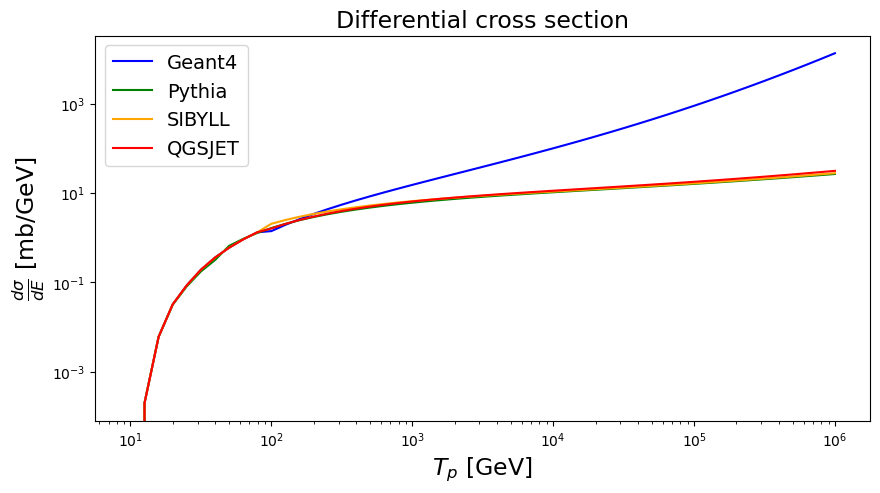

In [137]:
logT = np.arange(1, 6.1, 0.1)
T = 10**logT
E = 10

plt.figure(figsize=(10, 5))
plt.plot(T, diffcrossGeant4(T, E), color='blue', label='Geant4')
plt.plot(T, diffcrossPythia8(T, E), color='green', label='Pythia')
plt.plot(T, diffcrossSIBYLL(T, E), color='orange', label='SIBYLL')
plt.plot(T, diffcrossQGSJET(T, E), color='red', label='QGSJET')
plt.loglog()
#plt.xlim(1e2, 1e9)
#plt.ylim(1e3, 1e6)
plt.xlabel(r'$T_p$ [GeV]', fontsize=17)
plt.ylabel(r'$\frac{d\sigma}{dE}$ [mb/GeV]', fontsize=17)
plt.legend(ncol=1, fontsize=14, loc='upper left')
plt.title('Differential cross section', fontsize=17)